<a href="https://colab.research.google.com/github/BelhsanHmida/Stock-Market-Prediction-with-Sentiment-Analysis/blob/main/Stock_Market_Prediction_with_News_Headlines_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

##Importing Dependencies

In [115]:
# Import the libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import nltk
import re
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost
import lightgbm

In [ ]:
import yfinance as yf
import pandas as pd
import nltk
import re
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from pandas import DataFrame as df
from pandas import concat
import matplotlib.pyplot as plt

## Get data from yahoo finance

In [ ]:
# define dates
start_date='2016-10-01'
end_date='2017-01-01'
startstamp=20211001

AIU is the stock ticker for Meta

In [ ]:
past_data = yf.download('AIU', start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AIU']: Exception("%ticker%: Data doesn't exist for startDate = 1475294400, endDate = 1483246800")


In [ ]:
past_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


In [ ]:
past_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       0 non-null      float64
 1   High       0 non-null      float64
 2   Low        0 non-null      float64
 3   Close      0 non-null      float64
 4   Adj Close  0 non-null      float64
 5   Volume     0 non-null      float64
dtypes: float64(6)
memory usage: 0.0+ bytes


Get  news headlines dataset

In [ ]:
! pip install kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d notlucasp/financial-news-headlines

Dataset URL: https://www.kaggle.com/datasets/notlucasp/financial-news-headlines
License(s): CC0-1.0
  0% 0.00/3.91M [00:00<?, ?B/s]
100% 3.91M/3.91M [00:00<00:00, 118MB/s]


In [ ]:
!unzip financial-news-headlines.zip

Archive:  financial-news-headlines.zip
  inflating: cnbc_headlines.csv      
  inflating: guardian_headlines.csv  
  inflating: reuters_headlines.csv   


In [ ]:
cnbc_cols = ['Headlines','Time','Description']
reuters_headlines_cols = ['Headlines','Time','Description']
guardian_headline_cols = ['Time', 'Headlines']

cnbc_headlines = pd.read_csv('/content/cnbc_headlines.csv', names =  cnbc_cols)
cnbc_headlines = cnbc_headlines.dropna(axis = 0, how ='any')

guardian_headlines = pd.read_csv('/content/guardian_headlines.csv', names =  guardian_headline_cols)
guardian_headlines = guardian_headlines.dropna(axis = 0, how ='any')

reuters_headlines = pd.read_csv('/content/reuters_headlines.csv', names =  reuters_headlines_cols)
reuters_headlines = reuters_headlines.dropna(axis = 0, how ='any')


In [ ]:
cnbc_headlines

,Headlines,Time,Description
0,Headlines,Time,Description
1,Jim Cramer: A better way to invest in the Covi...,"7:51 PM ET Fri, 17 July 2020","""Mad Money"" host Jim Cramer recommended buying..."
2,Cramer's lightning round: I would own Teradyne,"7:33 PM ET Fri, 17 July 2020","""Mad Money"" host Jim Cramer rings the lightnin..."
4,"Cramer's week ahead: Big week for earnings, ev...","7:25 PM ET Fri, 17 July 2020","""We'll pay more for the earnings of the non-Co..."
5,IQ Capital CEO Keith Bliss says tech and healt...,"4:24 PM ET Fri, 17 July 2020","Keith Bliss, IQ Capital CEO, joins ""Closing Be..."
...,...,...,...
3076,Markets lack Christmas cheer,"10:15 AM ET Tue, 26 Dec 2017","According to Kensho, here's how markets have f..."
3077,Cramer Remix: The biggest mistake you can make...,"11:12 AM ET Thu, 20 Sept 2018",Jim Cramer revealed his top rule when it comes...
3078,Cramer says owning too many stocks and too lit...,"7:07 PM ET Fri, 22 Dec 2017",Jim Cramer broke down why owning fewer stocks ...
3079,Cramer: I helped investors through the 2010 fl...,"7:07 PM ET Fri, 22 Dec 2017","Jim Cramer built on his ""nobody ever made a di..."


In [ ]:
guardian_headlines

,Time,Headlines
0,Time,Headlines
1,18-Jul-20,Johnson is asking Santa for a Christmas recovery
2,18-Jul-20,‘I now fear the worst’: four grim tales of wor...
3,18-Jul-20,Five key areas Sunak must tackle to serve up e...
4,18-Jul-20,Covid-19 leaves firms ‘fatally ill-prepared’ f...
...,...,...
17796,17-Dec-17,How investing in solar energy can create a bri...
17797,17-Dec-17,Poundland suppliers hit by insurance downgrade
17798,17-Dec-17,Cryptocurrencies: City watchdog to investigate...
17799,17-Dec-17,Unilever sells household name spreads to KKR f...


In [ ]:
reuters_headlines

,Headlines,Time,Description
0,Headlines,Time,Description
1,TikTok considers London and other locations fo...,Jul 18 2020,TikTok has been in discussions with the UK gov...
2,Disney cuts ad spending on Facebook amid growi...,Jul 18 2020,Walt Disney has become the latest company to ...
3,Trail of missing Wirecard executive leads to B...,Jul 18 2020,Former Wirecard chief operating officer Jan M...
4,Twitter says attackers downloaded data from up...,Jul 18 2020,Twitter Inc said on Saturday that hackers were...
...,...,...,...
32766,Malaysia says never hired British data firm at...,Mar 20 2018,The Malaysian government and the ruling party ...
32767,Prosecutors search Volkswagen headquarters in ...,Mar 20 2018,German prosecutors said on Tuesday they had se...
32768,McDonald's sets greenhouse gas reduction targets,Mar 20 2018,McDonald's Corp on Tuesday announced an approv...
32769,Pratt & Whitney to deliver spare A320neo engin...,Mar 20 2018,Pratt & Whitney will soon begin deliveries of ...


#Picking the cnbc Dataset  

In [ ]:
cnbc_headlines = cnbc_headlines.iloc[1:]

In [ ]:
data = cnbc_headlines.copy()

In [ ]:
data.sample(50)

,Headlines,Time,Description
144,Cramer's lightning round: Penske Automotive is...,"8:33 PM ET Mon, 18 May 2020","""Mad Money"" host Jim Cramer rings the lightnin..."
1888,Marc Benioff says employees leaving big tech i...,"7:28 PM ET Tue, 27 Nov 2018",Jim Cramer and Salesforce.com chief Marc Benio...
462,These five S&P 500 stocks have the highest num...,"9:40 AM ET Sat, 15 Feb 2020","Amazon, Alphabet, Facebook, Salesforce and Pay..."
775,Airbnb could choose direct listing over IPO in...,"6:43 PM ET Mon, 18 Nov 2019","Most companies rushing to public markets ""need..."
651,Cramer Remix: Don't pass up free money from yo...,"11:35 AM ET Wed, 25 Dec 2019",Jim Cramer details how to take advantage of yo...
2438,"Cramer Remix: If the economy slows down, this ...","10:28 AM ET Fri, 15 June 2018",Jim Cramer reveals why FANG doesn’t need a str...
467,Cramer's week ahead: The coronavirus outbreak ...,"8:28 PM ET Fri, 14 Feb 2020","""Until the outbreak burns itself out, the coro..."
2613,Cramer: Domino's Pizza might have the best ear...,"7:07 PM ET Thu, 26 April 2018",Jim Cramer says Domino's Pizza might have the ...
2132,Cramer Remix: Don't overthink—the oil rally is...,"7:07 PM ET Tue, 25 Sept 2018",Jim Cramer explains why investors shouldn't le...
644,Cramer pinpoints the hardest part of individua...,"8:05 PM ET Fri, 27 Dec 2019",Jim Cramer argues that keeping your emotions i...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2800 entries, 1 to 3080
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Headlines    2800 non-null   object
 1   Time         2800 non-null   object
 2   Description  2800 non-null   object
dtypes: object(3)
memory usage: 87.5+ KB


In [ ]:
data.duplicated().sum()

0

In [ ]:
def clean_time_column(time_str):
    # Remove the "ET" part and any other unnecessary info
    clean_str = time_str.replace(" ET", "")
    return clean_str

In [ ]:
data['Date'] = data['Time'].apply(clean_time_column)

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])


In [ ]:
data

,Headlines,Time,Description,Date
1,Jim Cramer: A better way to invest in the Covi...,"7:51 PM ET Fri, 17 July 2020","""Mad Money"" host Jim Cramer recommended buying...",2020-07-17 19:51:00
2,Cramer's lightning round: I would own Teradyne,"7:33 PM ET Fri, 17 July 2020","""Mad Money"" host Jim Cramer rings the lightnin...",2020-07-17 19:33:00
4,"Cramer's week ahead: Big week for earnings, ev...","7:25 PM ET Fri, 17 July 2020","""We'll pay more for the earnings of the non-Co...",2020-07-17 19:25:00
5,IQ Capital CEO Keith Bliss says tech and healt...,"4:24 PM ET Fri, 17 July 2020","Keith Bliss, IQ Capital CEO, joins ""Closing Be...",2020-07-17 16:24:00
6,Wall Street delivered the 'kind of pullback I'...,"7:36 PM ET Thu, 16 July 2020","""Look for the stocks of high-quality companies...",2020-07-16 19:36:00
...,...,...,...,...
3076,Markets lack Christmas cheer,"10:15 AM ET Tue, 26 Dec 2017","According to Kensho, here's how markets have f...",2017-12-26 10:15:00
3077,Cramer Remix: The biggest mistake you can make...,"11:12 AM ET Thu, 20 Sept 2018",Jim Cramer revealed his top rule when it comes...,2018-09-20 11:12:00
3078,Cramer says owning too many stocks and too lit...,"7:07 PM ET Fri, 22 Dec 2017",Jim Cramer broke down why owning fewer stocks ...,2017-12-22 19:07:00
3079,Cramer: I helped investors through the 2010 fl...,"7:07 PM ET Fri, 22 Dec 2017","Jim Cramer built on his ""nobody ever made a di...",2017-12-22 19:07:00


In [ ]:
data.drop(columns= ['Time'],inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2800 entries, 1 to 3080
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Headlines    2800 non-null   object        
 1   Description  2800 non-null   object        
 2   Date         2800 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 152.0+ KB


In [ ]:
data

,Headlines,Description,Date
1,Jim Cramer: A better way to invest in the Covi...,"""Mad Money"" host Jim Cramer recommended buying...",2020-07-17 19:51:00
2,Cramer's lightning round: I would own Teradyne,"""Mad Money"" host Jim Cramer rings the lightnin...",2020-07-17 19:33:00
4,"Cramer's week ahead: Big week for earnings, ev...","""We'll pay more for the earnings of the non-Co...",2020-07-17 19:25:00
5,IQ Capital CEO Keith Bliss says tech and healt...,"Keith Bliss, IQ Capital CEO, joins ""Closing Be...",2020-07-17 16:24:00
6,Wall Street delivered the 'kind of pullback I'...,"""Look for the stocks of high-quality companies...",2020-07-16 19:36:00
...,...,...,...
3076,Markets lack Christmas cheer,"According to Kensho, here's how markets have f...",2017-12-26 10:15:00
3077,Cramer Remix: The biggest mistake you can make...,Jim Cramer revealed his top rule when it comes...,2018-09-20 11:12:00
3078,Cramer says owning too many stocks and too lit...,Jim Cramer broke down why owning fewer stocks ...,2017-12-22 19:07:00
3079,Cramer: I helped investors through the 2010 fl...,"Jim Cramer built on his ""nobody ever made a di...",2017-12-22 19:07:00


Choose the headlines before our EndDate

In [ ]:
start_date = '2018-07-17 19:51:00'
end_date = '2019-07-17 19:51:00'

In [ ]:
end_date = pd.to_datetime(end_date)
start_date= pd.to_datetime(start_date)

condition = (data['Date'] >= start_date) & (data['Date'] < end_date)

# Apply the condition to filter the DataFrame
df = data[condition]


In [ ]:
df

,Headlines,Description,Date
1189,"Cramer's lightning round: Amazon, Shopify leav...",Jim Cramer takes calls and gives his thoughts ...,2019-07-17 19:32:00
1190,Cramer: Sam Adams-parent Boston Beer is the co...,This is an important story that shows how comp...,2019-07-17 19:08:00
1193,Cramer: Earnings suggest business and consumer...,"""I can't think of another time … where the con...",2019-07-17 18:56:00
1194,Charts show the S&P 500 could be due for a cor...,"""The charts, as interpreted by Carley Garner, ...",2019-07-16 20:50:00
1195,Cramer Remix: Now is your chance to buy into t...,Jim Cramer explains why he thinks now is the t...,2019-07-16 20:37:00
...,...,...,...
2468,Cramer's investing rule for when company execu...,Jim Cramer says investors should sell their st...,2019-02-19 18:24:00
2469,"Cramer: To be a good investor, you have to und...",Jim Cramer argues that investors must understa...,2019-02-19 18:24:00
2470,Cramer: Don't be afraid to pay up for best-of-...,Jim Cramer explains why investors should alway...,2019-02-19 18:23:00
2505,Cramer Remix: Don’t let the earnings bonanza c...,Jim Cramer breaks down his game plan for next ...,2019-07-12 19:00:00


#Sentiment Analysis on the News data using :
- NLTK
- FinBERT model


In [79]:
News_data = df.copy()

In [60]:
News_data

,Headlines,Description,Date
1189,"Cramer's lightning round: Amazon, Shopify leav...",Jim Cramer takes calls and gives his thoughts ...,2019-07-17 19:32:00
1190,Cramer: Sam Adams-parent Boston Beer is the co...,This is an important story that shows how comp...,2019-07-17 19:08:00
1193,Cramer: Earnings suggest business and consumer...,"""I can't think of another time … where the con...",2019-07-17 18:56:00
1194,Charts show the S&P 500 could be due for a cor...,"""The charts, as interpreted by Carley Garner, ...",2019-07-16 20:50:00
1195,Cramer Remix: Now is your chance to buy into t...,Jim Cramer explains why he thinks now is the t...,2019-07-16 20:37:00
...,...,...,...
2468,Cramer's investing rule for when company execu...,Jim Cramer says investors should sell their st...,2019-02-19 18:24:00
2469,"Cramer: To be a good investor, you have to und...",Jim Cramer argues that investors must understa...,2019-02-19 18:24:00
2470,Cramer: Don't be afraid to pay up for best-of-...,Jim Cramer explains why investors should alway...,2019-02-19 18:23:00
2505,Cramer Remix: Don’t let the earnings bonanza c...,Jim Cramer breaks down his game plan for next ...,2019-07-12 19:00:00


In [64]:
# stemming news headlines
# this takes some time

nltk.download('stopwords')
ps = PorterStemmer()

# Download VADER's required resources
nltk.download('vader_lexicon')

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [65]:
test_df = News_data.sample(50)
test_df
def get_sentiment(text):
    sentiment = sia.polarity_scores(text)  # Get the sentiment scores
    return sentiment['compound']  # Extract the compound score (overall sentiment)

# Apply the function to the 'Description' column
test_df['Sentiment'] = test_df['Description'].apply(get_sentiment)

# Display the DataFrame with the new 'Sentiment' column
test_df

,Headlines,Description,Date,Sentiment
2167,"Cramer Remix: When it comes to trade, ignore T...",Jim Cramer explains why it's best to disregard...,2018-09-14 19:05:00,0.5994
1825,"Adobe CEO on Magento, Marketo deals making 'on...",Jim Cramer speaks with Adobe Chairman and CEO ...,2018-12-13 19:07:00,0.0000
1969,Cramer's lightning round: It's time to buy the...,Jim Cramer says it's time to buy Microsoft on ...,2018-11-02 20:11:00,-0.4215
1219,Cramer: We have 'real reason to be worried' ab...,"The weak forecast from BASF ""suggests that the...",2019-07-10 11:42:00,-0.3818
1955,Cramer's lightning round: This stock could rec...,Jim Cramer says a biotechnology stock could la...,2018-11-06 19:02:00,0.0000
1962,"Cramer: Despite his criticisms, President Trum...","""This is one of those situations where all pub...",2018-11-06 10:24:00,0.2500
1311,Tesla just finished its best day of the year,Tesla is still the worst performer of 2019 on ...,2019-06-04 18:05:00,-0.6249
1595,Cramer Remix: This tech stock is worth buying ...,Jim Cramer breaks down why Cisco Systems is a ...,2019-02-27 11:28:00,0.5106
2311,Cramer flags the 'clear winners' of earnings s...,Jim Cramer highlights the companies that wowed...,2018-07-30 18:57:00,0.5574
1472,Cramer: Investors must study up on the Amazon ...,"""Any company with any kind of consumer product...",2019-04-15 19:43:00,-0.7645


In [68]:
News_data['compound'] = [sia.polarity_scores(v)['compound'] for v in News_data['Description']]
News_data['negative'] = [sia.polarity_scores(v)['neg'] for v in News_data['Description']]
News_data['neutral'] = [sia.polarity_scores(v)['neu'] for v in News_data['Description']]
News_data['positive'] = [sia.polarity_scores(v)['pos'] for v in News_data['Description']]

In [69]:
News_data

,Headlines,Description,Date,compound,negative,neutral,positive
1189,"Cramer's lightning round: Amazon, Shopify leav...",Jim Cramer takes calls and gives his thoughts ...,2019-07-17 19:32:00,0.0000,0.000,1.000,0.000
1190,Cramer: Sam Adams-parent Boston Beer is the co...,This is an important story that shows how comp...,2019-07-17 19:08:00,-0.5423,0.153,0.783,0.064
1193,Cramer: Earnings suggest business and consumer...,"""I can't think of another time … where the con...",2019-07-17 18:56:00,0.6249,0.000,0.854,0.146
1194,Charts show the S&P 500 could be due for a cor...,"""The charts, as interpreted by Carley Garner, ...",2019-07-16 20:50:00,0.0000,0.000,1.000,0.000
1195,Cramer Remix: Now is your chance to buy into t...,Jim Cramer explains why he thinks now is the t...,2019-07-16 20:37:00,0.1779,0.000,0.941,0.059
...,...,...,...,...,...,...,...
2468,Cramer's investing rule for when company execu...,Jim Cramer says investors should sell their st...,2019-02-19 18:24:00,0.0000,0.000,1.000,0.000
2469,"Cramer: To be a good investor, you have to und...",Jim Cramer argues that investors must understa...,2019-02-19 18:24:00,-0.3182,0.119,0.822,0.059
2470,Cramer: Don't be afraid to pay up for best-of-...,Jim Cramer explains why investors should alway...,2019-02-19 18:23:00,0.2960,0.000,0.872,0.128
2505,Cramer Remix: Don’t let the earnings bonanza c...,Jim Cramer breaks down his game plan for next ...,2019-07-12 19:00:00,0.0000,0.000,1.000,0.000


In [78]:
filtered_df = News_data[News_data['negative'] > 0.1]
filtered_df

,Headlines,Description,Date,compound,negative,neutral,positive
1190,Cramer: Sam Adams-parent Boston Beer is the co...,This is an important story that shows how comp...,2019-07-17 19:08:00,-0.5423,0.153,0.783,0.064
1197,Cramer explains how the Fed is creating buying...,"""When you have a Fed chief who's hellbent on c...",2019-07-16 19:53:00,0.5106,0.125,0.673,0.202
1206,Cramer Remix: The stamp of approval to start b...,Jim Cramer breaks down why the stock's rally o...,2019-07-12 03:36:00,-0.4939,0.198,0.802,0.000
1207,There has been a paradigm shift in the weed in...,"""As the weak hands exit the cannabis space, in...",2019-07-12 18:37:00,-0.4404,0.216,0.671,0.113
1215,Jim Cramer gives 5 reasons why Wednesday's ral...,"The ""Mad Money"" host dispelled the idea that t...",2019-07-10 20:47:00,-0.4939,0.132,0.868,0.000
...,...,...,...,...,...,...,...
2339,Cramer Remix: Don’t despair about the transpor...,Jim Cramer explains why investors shouldn’t wo...,2018-07-18 19:06:00,-0.0258,0.147,0.711,0.142
2341,Cramer's take on retail REIT stocks: Their 're...,Jim Cramer says the retail resurgence is boost...,2018-07-18 18:57:00,-0.1759,0.118,0.754,0.128
2344,Cramer: If you own shares in companies with bu...,"Jim Cramer warns investors of Boeing, Caterpil...",2018-07-19 12:24:00,-0.8126,0.344,0.656,0.000
2466,Cramer Remix: When stock bargains are be too g...,Jim Cramer reveals how a second- or third-tier...,2019-02-19 19:01:00,-0.5216,0.174,0.826,0.000


## FinancialBERT Pre-trained Model


In [58]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

model = BertForSequenceClassification.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis",num_labels=3)
tokenizer = BertTokenizer.from_pretrained("ahmedrachid/from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

model = BertForSequenceClassification.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis",num_labels=3)
tokenizer = BertTokenizer.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis")

nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

sentences = ["Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales.",
             "Bids or offers include at least 1,000 shares and the value of the shares must correspond to at least EUR 4,000.",
             "Raute reported a loss per share of EUR 0.86 for the first half of 2009 , against EPS of EUR 0.74 in the corresponding period of 2008.",
             ]
results = nlp(sentences)
print(results)-Sentiment-Analysis")

nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

sentences = ["Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales.",
             "Bids or offers include at least 1,000 shares and the value of the shares must correspond to at least EUR 4,000.",
             "Raute reported a loss per share of EUR 0.86 for the first half of 2009 , against EPS of EUR 0.74 in the corresponding period of 2008.",
             ]
results = nlp(sentences)
print(results)


config.json:   0%|          | 0.00/789 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/369 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/464k [00:00<?, ?B/s]

[{'label': 'positive', 'score': 0.9998133778572083}, {'label': 'neutral', 'score': 0.9997822642326355}, {'label': 'negative', 'score': 0.9877365231513977}]


In [80]:
def bert_sentiment(df):
    # Initialize empty lists to store scores for positive, neutral, and negative sentiments
    positive_scores = []
    neutral_scores = []
    negative_scores = []

    # Iterate over each description in the DataFrame
    for description in df['Description']:
        # Get the sentiment analysis result
        results = nlp(description)

        # Initialize a dictionary to hold the scores for this description
        scores = {'positive': 0, 'neutral': 0, 'negative': 0}

        # Populate the dictionary with the scores from the analysis
        for result in results:
            label = result['label'].lower()
            score = result['score']
            scores[label] = score

        # Append the scores to the respective lists
        positive_scores.append(scores['positive'])
        neutral_scores.append(scores['neutral'])
        negative_scores.append(scores['negative'])

    # Add the scores as new columns to the DataFrame
    df['Positive_Score'] = positive_scores
    df['Neutral_Score'] = neutral_scores
    df['Negative_Score'] = negative_scores

    return df  # Return the updated DataFrame


# Apply the bert_sentiment function to add sentiment scores
result_df = bert_sentiment(News_data)

# Display the DataFrame with the new 'Sentiment' column
result_df

,Headlines,Description,Date,Positive_Score,Neutral_Score,Negative_Score
1189,"Cramer's lightning round: Amazon, Shopify leav...",Jim Cramer takes calls and gives his thoughts ...,2019-07-17 19:32:00,0.000000,0.999671,0.0
1190,Cramer: Sam Adams-parent Boston Beer is the co...,This is an important story that shows how comp...,2019-07-17 19:08:00,0.000000,0.999688,0.0
1193,Cramer: Earnings suggest business and consumer...,"""I can't think of another time … where the con...",2019-07-17 18:56:00,0.000000,0.992064,0.0
1194,Charts show the S&P 500 could be due for a cor...,"""The charts, as interpreted by Carley Garner, ...",2019-07-16 20:50:00,0.996508,0.000000,0.0
1195,Cramer Remix: Now is your chance to buy into t...,Jim Cramer explains why he thinks now is the t...,2019-07-16 20:37:00,0.000000,0.998231,0.0
...,...,...,...,...,...,...
2468,Cramer's investing rule for when company execu...,Jim Cramer says investors should sell their st...,2019-02-19 18:24:00,0.000000,0.972467,0.0
2469,"Cramer: To be a good investor, you have to und...",Jim Cramer argues that investors must understa...,2019-02-19 18:24:00,0.000000,0.999648,0.0
2470,Cramer: Don't be afraid to pay up for best-of-...,Jim Cramer explains why investors should alway...,2019-02-19 18:23:00,0.000000,0.999397,0.0
2505,Cramer Remix: Don’t let the earnings bonanza c...,Jim Cramer breaks down his game plan for next ...,2019-07-12 19:00:00,0.000000,0.998019,0.0


In [72]:
filtered_df = result_df[result_df['Negative_Score'] > 0.7]
filtered_df['Description'][1879]

"Jim Cramer says non-bank lending companies like Quicken Loans, PennyMac and LoanDepot could cause a financial crisis if the Federal Reserve doesn't regulate them."

##Stock Data EDA from YahooFinance

In [ ]:
meta_Symbol ='AIU'

In [ ]:
stock_data = yf.download('AIU', start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-07-17,293.000000,301.75,286.75,287.50,287.50,4352
2018-07-18,286.750000,296.00,280.25,286.75,286.75,7092
2018-07-19,284.500000,284.50,275.25,281.00,281.00,9376
2018-07-20,281.000000,288.00,279.25,281.00,281.00,8768
2018-07-23,281.000000,285.25,275.25,282.25,282.25,5348
...,...,...,...,...,...,...
2019-07-11,196.250000,201.25,192.75,197.75,197.75,1312
2019-07-12,198.500000,212.25,192.50,210.75,210.75,4880
2019-07-15,209.250000,217.25,202.75,207.75,207.75,6964


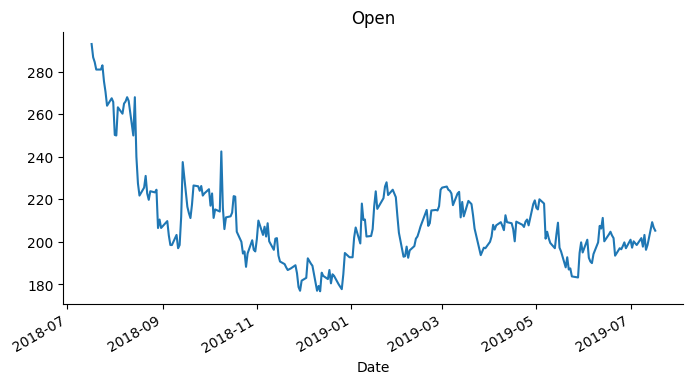

In [ ]:
# @title Open

from matplotlib import pyplot as plt
stock_data['Open'].plot(kind='line', figsize=(8, 4), title='Open')
plt.gca().spines[['top', 'right']].set_visible(False)

Text(0, 0.5, 'Meta')

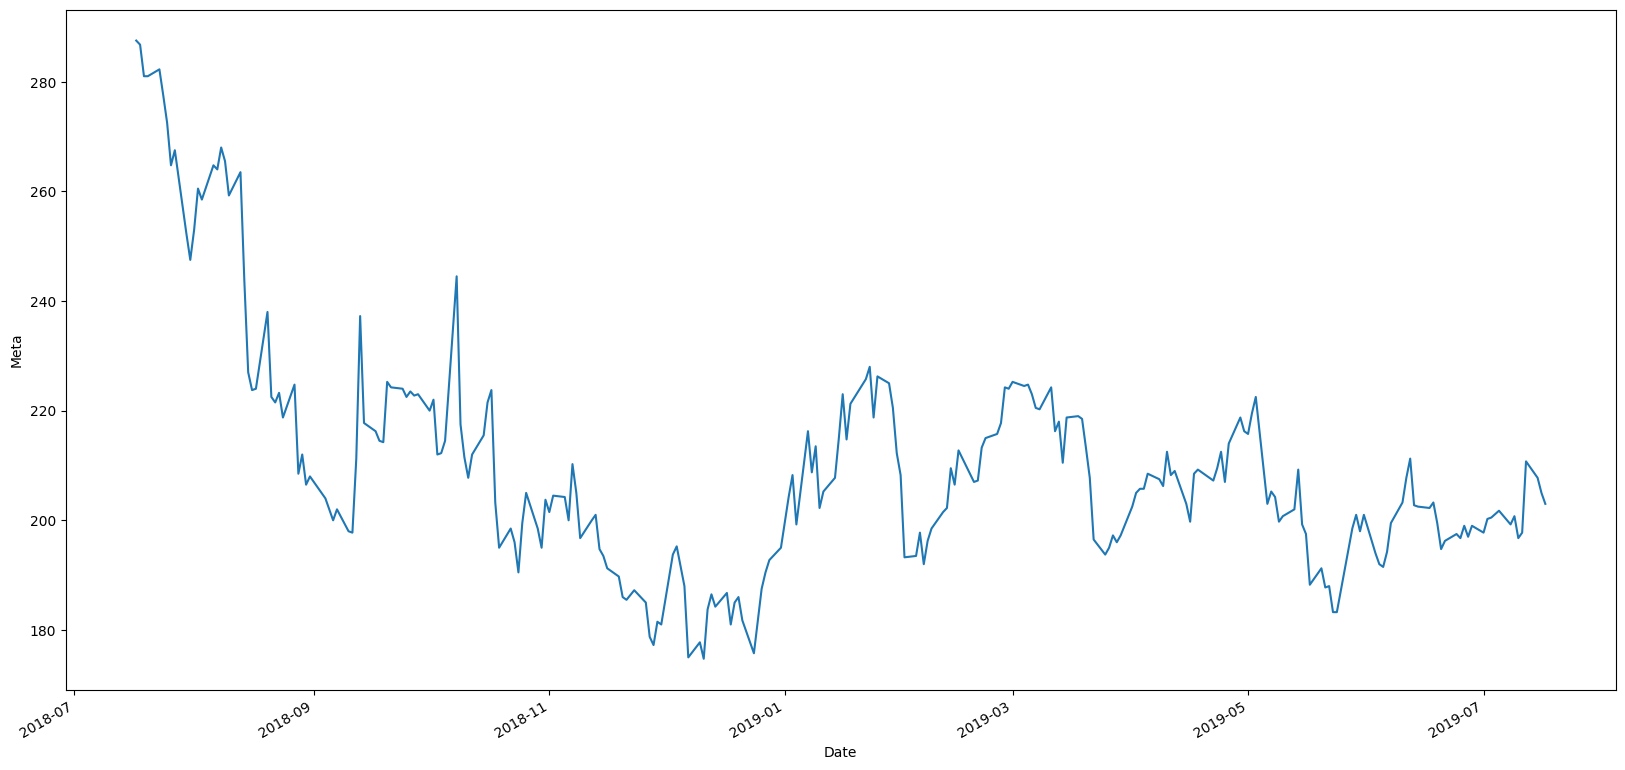

In [81]:
# Figure plot
plt.figure(figsize=(20,10))
stock_data['Close'].plot()
plt.ylabel('Meta')

**Plot the Moving Average**

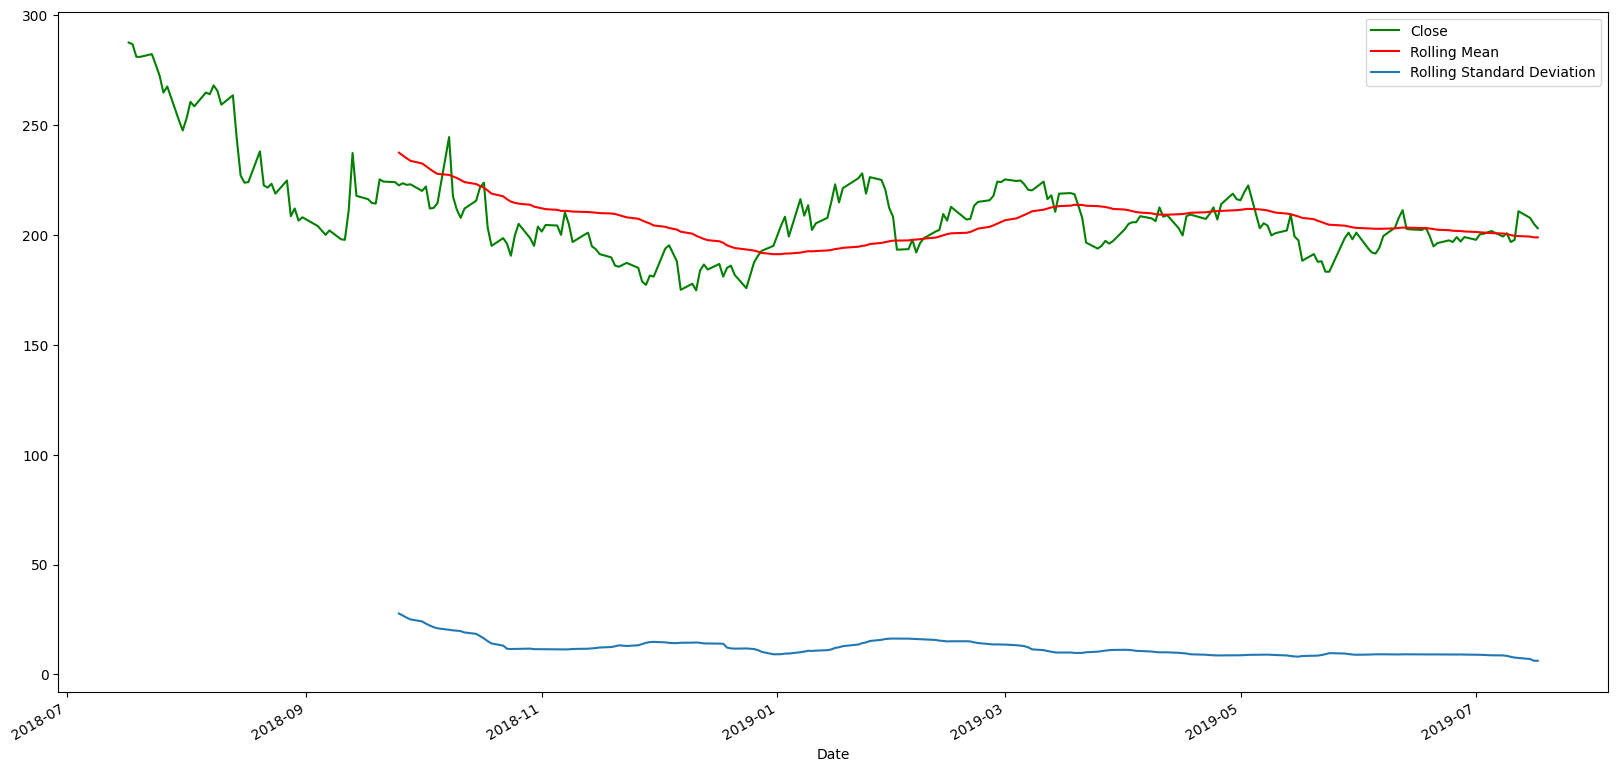

In [ ]:
#Plotting moving average
close = stock_data['Close']

ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(20,10))
stock_data['Close'].plot(color='g',label='Close')
ma.plot(color = 'r',label='Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')

plt.legend()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7009b38e/zotk9gn8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7009b38e/bcsfsqcd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96884', 'data', 'file=/tmp/tmp7009b38e/zotk9gn8.json', 'init=/tmp/tmp7009b38e/bcsfsqcd.json', 'output', 'file=/tmp/tmp7009b38e/prophet_model1jnq1ay6/prophet_model-20240510000003.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:00:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:00:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


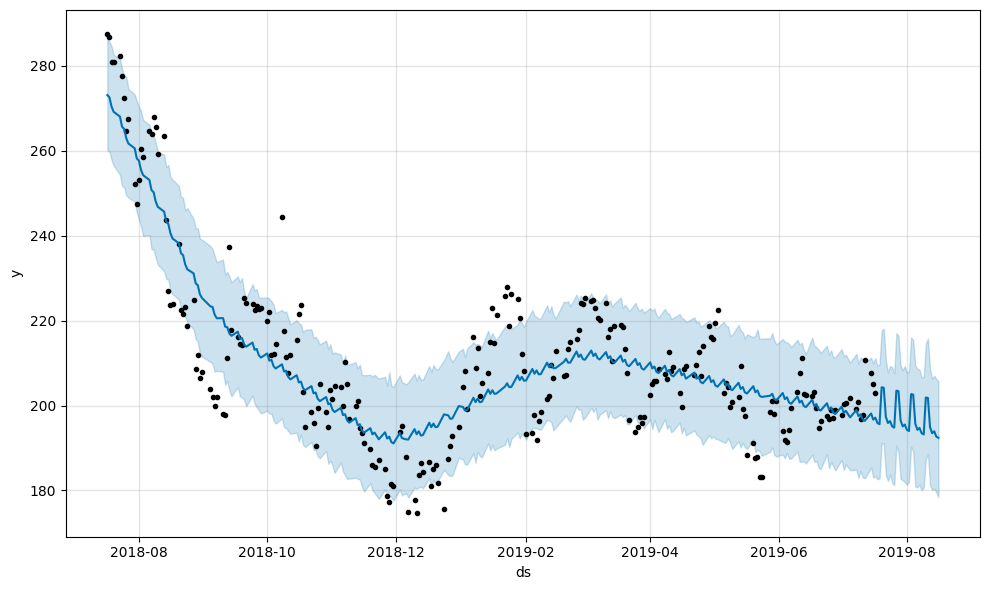

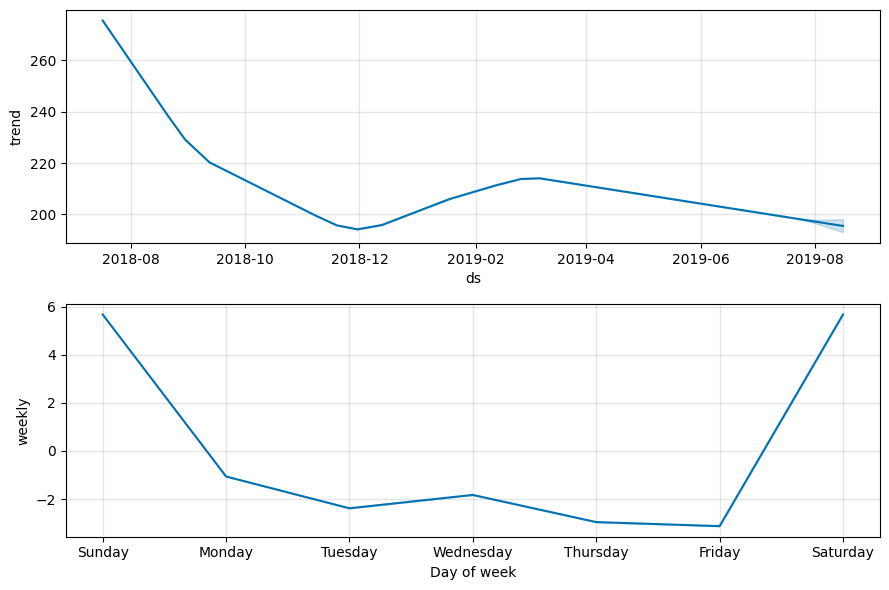

            ds        yhat  yhat_lower  yhat_upper
0   2018-07-17  273.103547  260.173475  286.660826
1   2018-07-18  272.594024  259.694604  285.649028
2   2018-07-19  270.397519  257.887788  284.663934
3   2018-07-20  269.163389  256.479240  282.574369
4   2018-07-23  268.034812  254.387031  281.638766
..         ...         ...         ...         ...
277 2019-08-12  194.922735  181.326214  208.602777
278 2019-08-13  193.483932  180.110505  206.292601
279 2019-08-14  193.925195  180.424615  207.021804
280 2019-08-15  192.679478  179.586768  206.237437
281 2019-08-16  192.396135  178.410886  205.720238

[282 rows x 4 columns]


In [82]:
from prophet import Prophet

# Prepare the data for Prophet
prophet_df = stock_data[['Close']].reset_index()  # Select only the 'Close' column and reset the index
prophet_df = prophet_df.rename(columns={'Date': 'ds', 'Close': 'y'})  # Rename columns for Prophet
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])  # Ensure 'ds' is in datetime format

# Initialize and fit the Prophet model
model = Prophet()
model.fit(prophet_df)

# Create a DataFrame for future dates (e.g., predict the next 30 days)
future = model.make_future_dataframe(periods=30)

# Predict future values
forecast = model.predict(future)

# Plot the forecast
import matplotlib.pyplot as plt
fig1 = model.plot(forecast)
plt.show()

# Plot forecast components (trend, seasonality, etc.)
fig2 = model.plot_components(forecast)
plt.show()

# Display key elements of the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

## Merging The Datasets

In [86]:
News_data['Date'] = df['Date'].dt.date

In [88]:
News_data = News_data.groupby('Date').agg({'Positive_Score': 'sum', 'Neutral_Score': 'sum', 'Negative_Score': 'sum'}).reset_index()


In [96]:
News_data['Date'] = pd.to_datetime(News_data['Date'])


In [90]:
stock_data = stock_data[['Close']].reset_index()

# Rename columns to work with Prophet
stock_data.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

In [93]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      252 non-null    datetime64[ns]
 1   y       252 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.1 KB


In [156]:
merged_df = pd.merge(stock_data, News_data, left_on='ds', right_on='Date', how='left')
merged_df.fillna({'Positive_Score': 0, 'Neutral_Score': 0, 'Negative_Score': 0}, inplace=True)


In [159]:
merged_df.drop(columns=['Date'],inplace=True)

In [160]:
merged_df

,ds,y,Positive_Score,Neutral_Score,Negative_Score
0,2018-07-17,287.50,0.000000,0.000000,0.000000
1,2018-07-18,286.75,0.898853,1.997552,0.999234
2,2018-07-19,281.00,0.999776,5.994018,0.998779
3,2018-07-20,281.00,0.000000,0.000000,0.000000
4,2018-07-23,282.25,1.940990,1.998373,0.000000
...,...,...,...,...,...
247,2019-07-11,197.75,0.999869,2.997130,0.000000
248,2019-07-12,210.75,0.994324,2.996624,0.000000
249,2019-07-15,207.75,0.996302,1.991687,0.000000
250,2019-07-16,205.00,1.972746,3.993389,0.614205


In [161]:
# Train test split
train = merged_df[:int(len(merged_df)*0.75)]
test = merged_df[int(len(merged_df)*0.75):]
News_data_train = News_data[:int(len(merged_df)*0.75)]
News_data_test = News_data[int(len(merged_df)*0.75):]

In [162]:
train

,ds,y,Positive_Score,Neutral_Score,Negative_Score
0,2018-07-17,287.50,0.000000,0.000000,0.000000
1,2018-07-18,286.75,0.898853,1.997552,0.999234
2,2018-07-19,281.00,0.999776,5.994018,0.998779
3,2018-07-20,281.00,0.000000,0.000000,0.000000
4,2018-07-23,282.25,1.940990,1.998373,0.000000
...,...,...,...,...,...
184,2019-04-10,212.50,0.000000,3.535561,0.000000
185,2019-04-11,208.25,2.827634,0.999739,0.000000
186,2019-04-12,209.00,0.999593,2.996008,0.000000
187,2019-04-15,203.00,0.840770,3.998500,0.989378


In [168]:
from prophet import Prophet

# Initialize the Prophet model
model = Prophet()

# Add custom regressors for sentiment
model.add_regressor('Positive_Score')
model.add_regressor('Neutral_Score')
model.add_regressor('Negative_Score')

In [169]:
# Fit the model with the merged data
model.fit(train)

# Create future DataFrame for prediction (e.g., predict the next 30 days)
future = model.make_future_dataframe(periods=30)

# Include the custom regressors in the future DataFrame
future = pd.merge(future, News_data_test[['Date', 'Positive_Score', 'Neutral_Score', 'Negative_Score']],
                  left_on='ds', right_on='Date', how='left')

# Fill missing values with 0 for custom regressors
future.fillna({'Positive_Score': 0, 'Neutral_Score': 0, 'Negative_Score': 0}, inplace=True)

# Predict future values
forecast = model.predict(future)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7009b38e/1jwuzrgv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7009b38e/nm6wl9pm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28087', 'data', 'file=/tmp/tmp7009b38e/1jwuzrgv.json', 'init=/tmp/tmp7009b38e/nm6wl9pm.json', 'output', 'file=/tmp/tmp7009b38e/prophet_modeld9pyosmj/prophet_model-20240510004028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:40:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:40:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


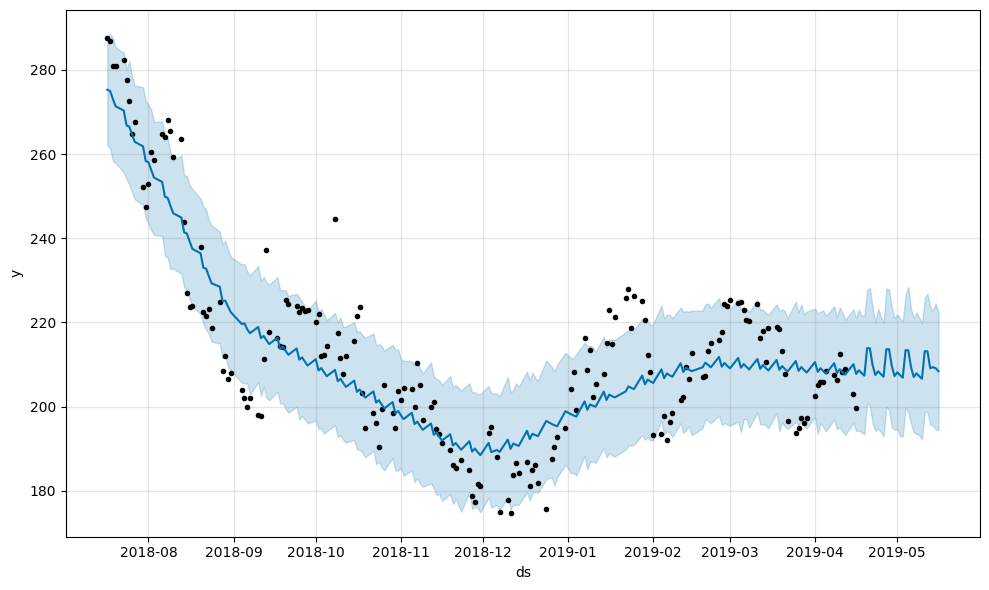

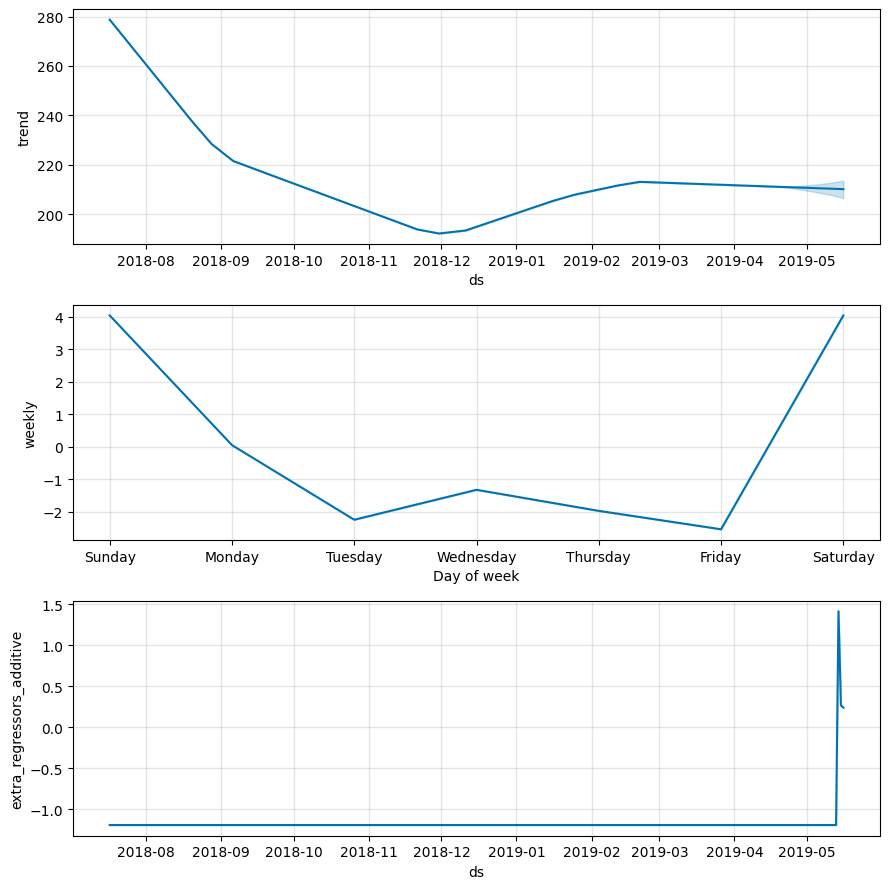

In [170]:
import matplotlib.pyplot as plt

# Plot the forecast
model.plot(forecast)
plt.show()

# Plot forecast components (trend, seasonality, etc.)
model.plot_components(forecast)
plt.show()

In [173]:
prediction = forecast[['ds','yhat_upper']]


In [172]:
test

,ds,y,Positive_Score,Neutral_Score,Negative_Score
189,2019-04-17,208.50,0.000000,4.614657,0.000000
190,2019-04-18,209.25,0.999799,2.997014,0.000000
191,2019-04-22,207.25,0.000000,0.000000,0.000000
192,2019-04-23,209.50,1.646765,1.998350,0.000000
193,2019-04-24,212.50,1.998111,0.999702,0.967558
...,...,...,...,...,...
247,2019-07-11,197.75,0.999869,2.997130,0.000000
248,2019-07-12,210.75,0.994324,2.996624,0.000000
249,2019-07-15,207.75,0.996302,1.991687,0.000000
250,2019-07-16,205.00,1.972746,3.993389,0.614205


In [174]:
prediction

,ds,yhat_upper
0,2018-07-17,287.988729
1,2018-07-18,288.542170
2,2018-07-19,287.673173
3,2018-07-20,285.369143
4,2018-07-23,284.066028
...,...,...
214,2019-05-12,226.819420
215,2019-05-13,223.790492
216,2019-05-14,222.733943
217,2019-05-15,224.507239


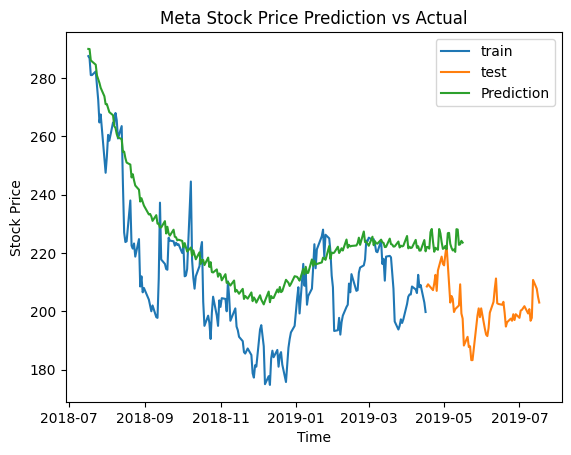

In [176]:

plt.plot(train['ds'], train['y'], label='train')
plt.plot(test['ds'], test['y'], label='test')
plt.plot(df['ds'], df['yhat_upper'], label='Prediction')
plt.title('Meta Stock Price Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [110]:
predicted = forecast[['ds', 'yhat']]

In [113]:
merged_df = pd.merge(stock_data, predicted, on='ds', how='right')

# Get the actual and predicted values
actual = merged_df['y']
predicted = merged_df['yhat']